### Validation of Tetrahedral Projection

This notebook is a set of tests to ensure that the tetrahedral partial parcel membership make sense.

**Context:**
- For simplicity in testing we'll use an identity affine matrix so that tetrahedral membership resolution in MR and RAS space is equivalent]
***

1. Tetrahedron grid test -- we systematically place tetrahedrons at various voxel boundaries with known partial memberships (by known it means 

2. Tetrahedral visualization and cross-validation with voxel membership -- visualize voxel placement and estimated membership. 

In [2]:
from scipy.spatial import ConvexHull
import nibabel as nib
import numpy as np
from nilearn import plotting, image
import matplotlib.pyplot as plt
from fieldopt import geolib, tetrapro

### Tetrahedron Grid Test 
Define an NxN array of pseudo-voxels. Then define several classes of tetrahedrons:
1. Fully embedded tetrahedrons -- expect full voxel ownership of tetrahedron
2. Horizontal/Vertically/Depthwise bordered tetrahedrons -- expect full ownership of tetrahedron
3. Horizontal/Vertically/Depthwise exclusive crossing -- expect 2 voxel ownership of tetrahedron
4. Multi-voxel ownership -- expect up to 8 voxel ownership of tetrahedron within adjacent voxel groups

In [3]:
#Define some hard variables
affine = np.eye(4)

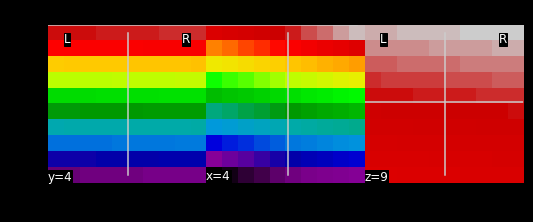

In [4]:
#Generate fake 3-dimensional grid for testing
N = 10
data_grid = np.ones((N**3)).cumsum()
data_grid = data_grid.reshape((N,N,N))

#So element numbering goes row, col, depth
data_grid = np.swapaxes(data_grid,0,2)
data = nib.Nifti1Image(data_grid,affine)
plotting.plot_epi(data)

In [118]:
#Make Class 1 testing coordinates
#For each "voxel index" pick 3 coordinates contained within the boundaries
def gen_class1_tet(n,shape):
    '''
    Generate <n> Class 1 (fully embedded) tetrahedrons within a data grid of shape <shape> 
    Returns a list of coordinates for each node as well as vertex ID for each tetrahedron
    
    Implementational Details:
    For each tetrahedron, select a voxel i,j,k in linear ordering
    Generate a (4x3) matrix of uniformly distributed variables, where n=4 describes the number of vertices 
        and m=3 describes the i,j,k coordinates respectively. 
        
    Adjust columns of the random matrix according to voxel identity to ensure complete embedding of tetrahedral
        vertices in voxel i,j,k
    '''

    node_ids = np.ones((n,4)).cumsum().reshape((n,4))
    coord_array = np.zeros((n*4,3))
    for i in np.arange(0,n):

        #Select voxel in shape
        step_z = i // (shape[0] * shape[1])
        step_y = i // (shape[0]) - shape[2]*step_z
        step_x = i - shape[1]*step_y - shape[1]*shape[2]*step_z
        selected_vox=(step_x,step_y,step_z)

        #Generate 4 sets of random integers within the boundaries defined by voxel
        rand_coords = np.random.random(size=(4,3))

        #Modify each value generated by boundariers defined by voxel 
        rand_coords[:,0] += step_x
        rand_coords[:,1] += step_y
        rand_coords[:,2] += step_z

        coord_array[4*i,:] = rand_coords[0,:]
        coord_array[4*i+1,:] = rand_coords[1,:]
        coord_array[4*i+2,:] = rand_coords[2,:]
        coord_array[4*i+3,:] = rand_coords[3,:]
        
    return node_ids, coord_array

In [ ]:
#Make Class 2 testing coordinates
def gen_class2_tet(n,shape):
    '''
    Generate <n> Class 2 (fully embedded bordered) tetrahedrons within a data grid of shape <shape> 
    Returns a list of coordinates for each node as well as a vertex ID for each tetrahedron
    
    Implementational Details: 
    For each tetrahedron, select a voxel i,j,k in linear ordering
    Out of all possibilities of 2 adjacent faces unioned with the set of single faces pick 1 scenario
    If 2 faces:
        Select v1 to be a corner of the adjacent faces
        Select v2 to be on either face1 or face2
        Select v3 to be on the opposite face
        Select v4 to be on the intersecting edge between the two faces
    If 1 face:
        Select v1,v2,v3 to be positioned on the face
        Select v4 randomly inside the cube
    '''
    
    node_ids = np.ones((n,4)).cumsum().reshape((n,4))
    coord_array = np.array((n*4,3))
    for i in np.arange(0,n):
        
        #Select voxel in shape
        step_z = i // (shape[0] * shape[1])
        step_y = i // (shape[0]) - shape[2]*step_z
        step_x = i - shape[1]*step_y - shape[1]*shape[2]*step_z
        selected_vox=(step_x,step_y,step_z)
        
        #Pick a face